This notebook is computing kinetic energy budget terms for one-layer simulations and save the time-averaged fields in a single netcdf file for further analysis.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dask
import dask.distributed
from xgcm import Grid
%matplotlib inline

from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:41255 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 406.01 GB


In [2]:
# read ocean.stats.nc files for all runs

ppdir = "/work/eay/MOM6/EddySaturation/"
tau = ['tau_1', 'tau_3', 'tau_5', 'tau_10', 'tau_30', 'tau_50', 'tau_100']

dataset_FW = []
dataset_VW = []

for i in range(0, len(tau)):
    d = xr.open_dataset(ppdir+"Fixed_width_jet/Wind_stress_"+tau[i]+"/ocean.stats.nc") 
    dataset_FW.append(d)
    d = xr.open_dataset(ppdir+"Var_width_jet/Wind_stress_"+tau[i]+"/ocean.stats.nc") 
    dataset_VW.append(d)
    
ds_FW = xr.concat(dataset_FW, dim='tau')
ds_VW = xr.concat(dataset_VW, dim='tau')

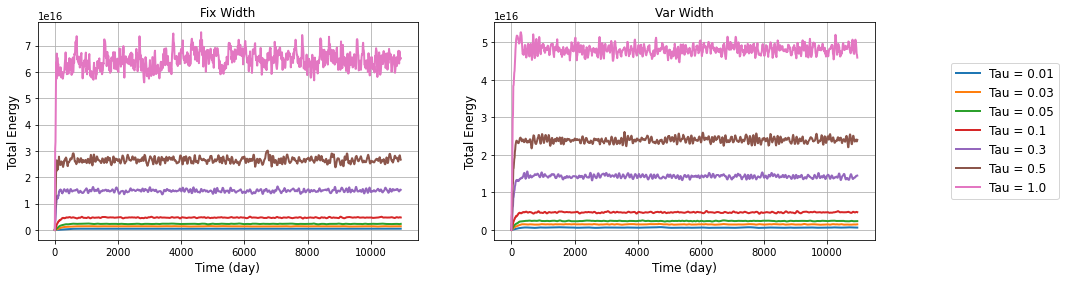

In [3]:
fig = plt.figure(figsize=[15,4])


# Plot total energy, layerwise KE, CFL 
leg = ['0.01', '0.03', '0.05', '0.1', '0.3', '0.5', '1.0']

plt.subplot(1,2,1)
plt.plot(ds_FW['Time']/(24*3600*1e9), ds_FW['En'].transpose(), lw=2)
plt.ylabel('Total Energy',fontsize=12)
plt.xlabel('Time (day)',fontsize=12)
plt.grid()
plt.title('Fix Width')

plt.subplot(1,2,2)
plt.plot(ds_VW['Time']/(24*3600*1e9), ds_VW['En'].transpose(), lw=2)
plt.ylabel('Total Energy',fontsize=12)
plt.xlabel('Time (day)',fontsize=12)
plt.grid()
plt.title('Var Width')
plt.legend([ 'Tau = ' + str(lag) for lag in leg], loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize=12)

In [18]:
# read prog_avg.nc files for all runs

tau = ['tau_1', 'tau_3', 'tau_5', 'tau_10', 'tau_30', 'tau_50', 'tau_100']
ta = ['1.0', '3.0', '5.0', '10.0', '30.0', '50.0', '100.0']

ppdir = "/work/eay/MOM6/EddySaturation/"

ppdir_tau = "/nbhome/Hemant.Khatri/Topography-Eddy-MOM6/input-files/"

#case = "Fixed_width_jet/Wind_stress_"; case_tau = "wind_stress_FW_tau_"
case = "Var_width_jet/Wind_stress_"; case_tau = "wind_stress_VW_tau_"

dataset_ds = []

for i in range(0, len(tau)):
    d = xr.open_dataset(ppdir+case+tau[i]+"/prog_avg.nc", chunks={'Time': 10})
    d1 = xr.open_dataset(ppdir_tau+"wind_stress_FW_tau_" + ta[i] + ".nc")
    d['taux'] = xr.DataArray(d1['taux'].values,dims=['yh','xq'])
    # specifying chunks is required for parallel computations
    dataset_ds.append(d)

ds = xr.concat(dataset_ds, dim='tau')


ds = ds.isel(Time=slice(730,1095)) # last 10 years of data

print(ds)

/home/Hemant.Khatri/anaconda3/envs/analysis/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


<xarray.Dataset>
Dimensions:     (Time: 365, nv: 2, tau: 7, xh: 400, xq: 400, yh: 800, yq: 800, zl: 1)
Coordinates:
  * Time        (Time) object 0021-01-01 00:00:00 ... 0030-12-20 00:00:00
  * xq          (xq) float64 4.0 8.0 12.0 16.0 ... 1.592e+03 1.596e+03 1.6e+03
  * yh          (yh) float64 2.0 6.0 10.0 14.0 ... 3.19e+03 3.194e+03 3.198e+03
  * zl          (zl) float64 1.028e+03
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 2.0 6.0 10.0 14.0 ... 1.59e+03 1.594e+03 1.598e+03
  * yq          (yq) float64 4.0 8.0 12.0 16.0 ... 3.192e+03 3.196e+03 3.2e+03
Dimensions without coordinates: tau
Data variables:
    u           (tau, Time, zl, yh, xq) float32 dask.array<chunksize=(1, 10, 1, 800, 400), meta=np.ndarray>
    v           (tau, Time, zl, yq, xh) float32 dask.array<chunksize=(1, 10, 1, 800, 400), meta=np.ndarray>
    h           (tau, Time, zl, yh, xh) float32 dask.array<chunksize=(1, 10, 1, 800, 400), meta=np.ndarray>
    uh          (tau, Time, zl, yh, xq) 

In [19]:
ppdir = "/nbhome/Hemant.Khatri/Topography-Eddy-MOM6/input-files/" 
topo = xr.open_dataset(ppdir+"topography_2L.nc")
ds['depth'] = xr.DataArray(topo['depth'].values,dims=['yh','xh'])

# Grid define for computations 
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X']);
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xh --> right
  * right    xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> right
  * right    yq --> center

$\Large \text{Eddy-mean decomposition}$

In [20]:
# Compute meand and eddy components 

# Reynolds Decomposition
um_Rey = ds['u'].mean('Time') 
vm_Rey = ds['v'].mean('Time')
hm_Rey = ds['h'].mean('Time')

ue_Rey = ds['u'] - um_Rey 
ve_Rey = ds['v'] - vm_Rey
he_Rey = ds['h'] - hm_Rey

# Thickness-weighted Decomposition
dx, dy = (4000., 4000.)

hmu = grid.interp(hm_Rey, 'X', boundary='fill') # Interpolate mean on u, v points
hmv = grid.interp(hm_Rey, 'Y', boundary='fill') # use 'fill' to put zeros on boundaries

um_TW = ds['uh'].mean('Time') / (hmu * dy)
vm_TW = ds['vh'].mean('Time') / (hmv * dx)

ue_TW = ds['u'] - um_TW
ve_TW = ds['v'] - vm_TW

# montgomery potentials for eddy and mean flow
g = 9.81
rho = ds['zl'].values
phi =  g * rho * (ds['h'] - ds['depth'])

In [21]:
# Compute mean and eddy kinetic energies

MKE_u = 0.5 * rho * hmu * um_TW * um_TW
MKE_v = 0.5 * rho * hmv * vm_TW * vm_TW

hu = grid.interp(ds['h'], 'X', boundary='fill')
hv = grid.interp(ds['h'], 'Y', boundary='fill')

EKE_u = 0.5 * rho * (hu * ue_TW * ue_TW).mean('Time')
EKE_v = 0.5 * rho * (hv * ve_TW * ve_TW).mean('Time')

$\Large \text{Kinetic energy budget terms}$

In [22]:
dx, dy = (4000., 4000.)

# del.(u MKE) and del.(u EKE) terms
tmp1 = - grid.diff(um_TW * MKE_u, 'X', boundary='fill') / dx
tmp2 = - grid.diff(vm_TW * MKE_v, 'Y', boundary='fill') / dy

MKE_bdt1 = tmp1 + tmp2

tmp1 = - grid.diff(um_TW * EKE_u + (ue_TW * EKE_u).mean('Time'), 'X', boundary='fill') / dx
tmp2 = - grid.diff(vm_TW * EKE_v + (ve_TW * EKE_v).mean('Time'), 'Y', boundary='fill') / dy

EKE_bdt1 = tmp1 + tmp2

# Reynolds stress term 

tmp1 = (grid.diff((hu * ue_TW * ue_TW), 'X', boundary='fill') / dx) * (grid.interp(um_TW, 'X', boundary='fill'))

tp = ds['h'] * grid.interp(ue_TW, 'X', boundary='fill') * grid.interp(ve_TW, 'Y', boundary='fill') 

tmp2 = (grid.interp(grid.diff(tp, 'Y', boundary='fill') / dy, 'Y', boundary='fill') *
        grid.interp(um_TW, 'X', boundary='fill'))

tmp3 = (grid.interp(grid.diff(tp, 'X', boundary='fill') / dx, 'X', boundary='fill') *
        grid.interp(vm_TW, 'Y', boundary='fill'))

tmp4 = (grid.diff((hv * ve_TW * ve_TW), 'Y', boundary='fill') / dy) * (grid.interp(vm_TW, 'Y', boundary='fill'))

EKE_bdt3 = rho * (tmp1 + tmp2 + tmp3 + tmp4).mean('Time')

MKE_bdt3 = - EKE_bdt3

# form stress term

phi_m = phi.mean('Time')
phi_e = phi - phi_m

tmp1 = hm_Rey * grid.interp( um_TW * grid.diff(phi_m, 'X', boundary='fill') / dx, 'X', boundary='fill')
tmp2 = hm_Rey * grid.interp( vm_TW * grid.diff(phi_m, 'Y', boundary='fill') / dy, 'Y', boundary='fill')

tp = grid.interp(he_Rey, 'X', boundary='fill') * grid.diff(phi_e, 'X', boundary='fill') / dx
tmp3 = grid.interp( um_TW * tp.mean('Time'),  'X', boundary='fill')

tp = grid.interp(he_Rey, 'Y', boundary='fill') * grid.diff(phi_e, 'Y', boundary='fill') / dy
tmp4 = grid.interp( vm_TW * tp.mean('Time'),  'Y', boundary='fill')

MKE_bdt2 = - (tmp1 + tmp2 + tmp3 + tmp4)

tmp1 = grid.interp(ue_TW * hu * grid.diff(phi_e, 'X', boundary='fill') / dx, 'X', boundary='fill')
tmp2 = grid.interp( ve_TW * hv * grid.diff(phi_e, 'Y', boundary='fill') / dy, 'Y', boundary='fill')

EKE_bdt2 = - (tmp1 + tmp2).mean('Time')

# Forcing and friction terms

tmp1 = grid.interp(ds['taux'] * um_TW, 'X', boundary='fill')

tmp2 = - (grid.interp(ds['taux_bot'].mean('Time') * um_TW, 'X', boundary='fill'))
          #+ grid.interp(ds['tauy_bot'].mean('Time') * vm_TW, 'Y', boundary='fill'))

MKE_bdt4 = tmp1 + tmp2

tmp1 = grid.interp(ds['taux'] * ue_TW.mean('Time'), 'X', boundary='fill')

tmp2 = - (grid.interp((ds['taux_bot'] * ue_TW).mean('Time'), 'X', boundary='fill'))
          #+ grid.interp((ds['tauy_bot'] * ve_TW).mean('Time'), 'Y', boundary='fill'))

EKE_bdt4 = tmp1 + tmp2

In [23]:
ds_save = xr.Dataset()

ds_save['MKE_bdt1'] = MKE_bdt1.load()
ds_save['MKE_bdt1'].attrs['standard_name'] = "MKE - Divergence of u*KE"
ds_save['MKE_bdt1'].attrs['units'] = "J/m^2"

ds_save['EKE_bdt1'] = EKE_bdt1.load()
ds_save['EKE_bdt1'].attrs['standard_name'] = "EKE - Divergence of u*KE"
ds_save['EKE_bdt1'].attrs['units'] = "J/m^2"

ds_save['MKE_bdt2'] = MKE_bdt2.load()
ds_save['MKE_bdt2'].attrs['standard_name'] = "MKE - Reynolds stress term"
ds_save['MKE_bdt2'].attrs['units'] = "J/m^2"

ds_save['EKE_bdt2'] = EKE_bdt2.load()
ds_save['EKE_bdt2'].attrs['standard_name'] = "EKE - Reynolds stress term"
ds_save['EKE_bdt2'].attrs['units'] = "J/m^2"

ds_save['MKE_bdt3'] = MKE_bdt3.load()
ds_save['MKE_bdt3'].attrs['standard_name'] = "MKE - Form stress term"
ds_save['MKE_bdt3'].attrs['units'] = "J/m^2"

ds_save['EKE_bdt3'] = EKE_bdt3.load()
ds_save['EKE_bdt3'].attrs['standard_name'] = "EKE - Form stress term"
ds_save['EKE_bdt3'].attrs['units'] = "J/m^2"

ds_save['MKE_bdt4'] = MKE_bdt4.load()
ds_save['MKE_bdt4'].attrs['standard_name'] = "MKE - Forcing and friction"
ds_save['MKE_bdt4'].attrs['units'] = "J/m^2"

ds_save['EKE_bdt4'] = EKE_bdt4.load()
ds_save['EKE_bdt4'].attrs['standard_name'] = "EKE - Forcing and friction"
ds_save['EKE_bdt4'].attrs['units'] = "J/m^2"

ds_save['depth'] = ds['depth']
ds_save['depth'].attrs['standard_name'] = "Ocean Depth"
ds_save['depth'].attrs['units'] = "m"

ds_save['taux'] = ds['taux']
ds_save['taux'].attrs['standard_name'] = "Zonal wind stress"
ds_save['taux'].attrs['units'] = "N/m^2"

print(ds_save)

<xarray.Dataset>
Dimensions:   (tau: 7, xh: 400, xq: 400, yh: 800, zl: 1)
Coordinates:
  * zl        (zl) float64 1.028e+03
  * yh        (yh) float64 2.0 6.0 10.0 14.0 ... 3.19e+03 3.194e+03 3.198e+03
  * xh        (xh) float64 2.0 6.0 10.0 14.0 ... 1.59e+03 1.594e+03 1.598e+03
  * xq        (xq) float64 4.0 8.0 12.0 16.0 ... 1.592e+03 1.596e+03 1.6e+03
Dimensions without coordinates: tau
Data variables:
    MKE_bdt1  (tau, zl, yh, xh) float64 4.223e-16 5.007e-16 ... nan nan
    EKE_bdt1  (tau, zl, yh, xh) float64 1.847e-13 2.039e-13 ... nan nan
    MKE_bdt2  (tau, zl, yh, xh) float64 3.709e-08 7.641e-09 2.73e-09 ... nan nan
    EKE_bdt2  (tau, zl, yh, xh) float64 -8.05e-07 -1.406e-06 ... nan nan
    MKE_bdt3  (tau, zl, yh, xh) float64 1.23e-13 1.377e-13 1.541e-13 ... nan nan
    EKE_bdt3  (tau, zl, yh, xh) float64 -1.23e-13 -1.377e-13 ... nan nan
    MKE_bdt4  (tau, yh, xh, zl) float64 -1.885e-11 -1.726e-11 ... -1.074e-05
    EKE_bdt4  (tau, yh, xh, zl) float64 -6.25e-09 -6.517e-09 .

In [24]:
# Save Data

save_path = "/work/Hemant.Khatri/MOM6_idealised/SWM_Two_Layer/Barotropic_Baroclinic/Postprocessing/Energetics/"

if (case == "Fixed_width_jet/Wind_stress_"):
    filename = "1L_Fix_width.nc"
elif(case == "Var_width_jet/Wind_stress_"):
    filename = "1L_Var_Width.nc"

ds_save.load().to_netcdf(save_path + filename)

In [25]:
ds.close()
ds_save.close()
client.close()
cluster.close()